https://www.bgc-jena.mpg.de/wetter/

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

Seq2seq technique works well for small sequences, but when the length of the sequence increases it is very difficult to summarize a long sequence into a single vector, and then model often forgets the earlier parts of the input sequence when processing the last parts. This is the reason why many experiments show that the performance of this model decreases as the size of the sequence increases.

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model 

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [6]:
# feature selection
data_selected = data.iloc[:, [0,1,4,8,16,20]]
display(data_selected.head())

,p (mbar),T (degC),rh (%),sh (g/kg),SWDR (W/m²),CO2 (ppm)
Date Time,,,,,,
01.07.2022 00:10:00,984.33,22.42,84.7,14.67,0.0,447.2
01.07.2022 00:20:00,984.36,22.02,86.8,14.67,0.0,445.6
01.07.2022 00:30:00,984.35,21.77,87.9,14.63,0.0,443.1
01.07.2022 00:40:00,984.27,22.00,85.6,14.45,0.0,443.4
01.07.2022 00:50:00,984.36,22.23,84.0,14.38,0.0,444.4


In [7]:
col_names = list(data_selected.columns)
colors = ['b','g','r','c','m','y']

In [8]:
# for i in range(data_selected.shape[1]):
#     plt.figure(figsize=(15,6))
#     plt.plot(data_selected.iloc[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data_selected)


In [10]:
# train and test split
test_size = 1008
train = data_scaled[:-test_size,:]
test = data_scaled[-test_size:,:]

In [11]:
data_scaled.shape

(31930, 6)

In [12]:
def plot_histogram(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])

    plt.show()

In [13]:
def plot_boxplot(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])

    plt.show()

In [14]:
# plot_histogram(3,2,train,col_names,colors)

In [15]:
# plot_boxplot(3,2,train,col_names,colors)

In [16]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-200,anomaly_idx_list[i]+201):
            if(train.shape[0]-201>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        if size!=0:
            train[anomaly_idx_list[i],index] = mean/size
    return train

In [17]:
isolation_forest = IsolationForest(contamination=0.01)

for idx in range(train.shape[1]):
    dt_feature = [[item] for item in train[:,idx]]
    isolation_forest.fit(dt_feature)
    pred = isolation_forest.predict(dt_feature)
    anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
    train = remove_anomaly(train,idx,anomaly)
    
    anomaly_val = []
    for i in range(len(anomaly)):
        anomaly_val.append(dt_feature[anomaly[i]])
#     plt.plot(dt_feature,color='b')
#     plt.title(col_names[idx])
#     plt.scatter(anomaly,anomaly_val,color='r')
#     plt.legend(['original','anomaly'], loc='upper right')
#     plt.show()



In [18]:
# print(train)
# plot_boxplot(3,2,train,col_names,colors)

In [19]:
# for i in range(train.shape[1]):
#     plt.plot(train[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()


In [20]:
# for i in range(test.shape[1]):
#     plt.plot(test[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [21]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
n_features = 6
n_steps_in = 150
n_steps_out = 100
X_train, y_train = split_sequences(train,n_steps_in,n_steps_out)
X_test, y_test = split_sequences(test,n_steps_in,n_steps_out)

In [23]:
# print(train[0:n_steps_in+n_steps_out,:])
# print("---------------------------------------------------------------")
# print(X_train[0:1,:])
# print("---------------------------------------------------------------")
# print(y_test[0:1,:])
# print("---------------------------------------------------------------")
print(train.shape)
print(test.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30922, 6)
(1008, 6)
(307, 150, 6) (307, 100, 6)
(8, 150, 6) (8, 100, 6)


In [24]:
# y_train = y_train.reshape(y_train.shape[0],n_steps_out*n_features)
# y_test = y_test.reshape(y_test.shape[0],n_steps_out*n_features)
print(y_train.shape)
print(y_test.shape)

(307, 100, 6)
(8, 100, 6)


In [25]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch %150 == 0 and epoch > 0:
        lr = lr * 0.9   
    return lr

# early stopping and model chackpoint
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor="val_loss",verbose=1,patience=200, mode="min",min_delta=0.00001)
model_checkpoint = ModelCheckpoint("best_model_seq2seq.h5",monitor="val_loss",verbose=1,save_best_only=True)

In [26]:
# seq2seq model encoder
encoder_inputs = Input(shape=(n_steps_in,n_features))
encoder_lstm = LSTM(32,recurrent_activation="tanh", dropout=0.2,return_sequences=True)
encoder_lstm2 = LSTM(64,return_state=True,recurrent_activation="tanh",dropout=0.2)
encoder_outputs = encoder_lstm(encoder_inputs)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)
encoder_states = [state_h,state_c]

# seq2seq model decoder
decoder_inputs = Input(shape=(n_steps_out,n_features))
decoder_lstm = LSTM(64,return_sequences=True,recurrent_activation="tanh",dropout=0.2,return_state=True)
decoder_outputs,_,_ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(n_features)
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 6)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 150, 32)      4992        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 6)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 64),         24832       ['lstm[0][0]']                   
                                 (None, 64),                                                  

In [27]:
# 
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
epochs = 5000
validation_split = 0.3 # 30% validation set
history = model.fit(x=[X_train,np.zeros((X_train.shape[0],n_steps_out,n_features))], y=y_train, epochs=epochs,batch_size=2,  verbose=1,validation_split=validation_split,shuffle=False,callbacks=[early_stopping,model_checkpoint,learning_rate_scheduler])

Epoch 1/5000
107/107 [==============================] - ETA: 0s - loss: 0.3883
Epoch 1: val_loss improved from inf to 0.50636, saving model to best_model_seq2seq.h5
107/107 [==============================] - 23s 170ms/step - loss: 0.3883 - val_loss: 0.5064 - lr: 1.0000e-04
Epoch 2/5000
107/107 [==============================] - ETA: 0s - loss: 0.3803
Epoch 2: val_loss improved from 0.50636 to 0.49715, saving model to best_model_seq2seq.h5
107/107 [==============================] - 17s 159ms/step - loss: 0.3803 - val_loss: 0.4972 - lr: 1.0000e-04
Epoch 3/5000
107/107 [==============================] - ETA: 0s - loss: 0.3693
Epoch 3: val_loss improved from 0.49715 to 0.46633, saving model to best_model_seq2seq.h5
107/107 [==============================] - 17s 160ms/step - loss: 0.3693 - val_loss: 0.4663 - lr: 1.0000e-04
Epoch 4/5000
107/107 [==============================] - ETA: 0s - loss: 0.2662
Epoch 4: val_loss improved from 0.46633 to 0.12293, saving model to best_model_seq2seq.h5
1

107/107 [==============================] - 18s 164ms/step - loss: 0.0669 - val_loss: 0.0501 - lr: 1.0000e-04
Epoch 33/5000
107/107 [==============================] - ETA: 0s - loss: 0.0655
Epoch 33: val_loss did not improve from 0.04752
107/107 [==============================] - 17s 159ms/step - loss: 0.0655 - val_loss: 0.0491 - lr: 1.0000e-04
Epoch 34/5000
107/107 [==============================] - ETA: 0s - loss: 0.0617
Epoch 34: val_loss did not improve from 0.04752
107/107 [==============================] - 18s 165ms/step - loss: 0.0617 - val_loss: 0.0482 - lr: 1.0000e-04
Epoch 35/5000
107/107 [==============================] - ETA: 0s - loss: 0.0624
Epoch 35: val_loss did not improve from 0.04752
107/107 [==============================] - 19s 177ms/step - loss: 0.0624 - val_loss: 0.0475 - lr: 1.0000e-04
Epoch 36/5000
107/107 [==============================] - ETA: 0s - loss: 0.0611
Epoch 36: val_loss improved from 0.04752 to 0.04738, saving model to best_model_seq2seq.h5
107/107 [

Epoch 99/5000
107/107 [==============================] - ETA: 0s - loss: 0.0306
Epoch 99: val_loss did not improve from 0.03398
107/107 [==============================] - 17s 161ms/step - loss: 0.0306 - val_loss: 0.0409 - lr: 1.0000e-04
Epoch 100/5000
107/107 [==============================] - ETA: 0s - loss: 0.0310
Epoch 100: val_loss did not improve from 0.03398
107/107 [==============================] - 17s 160ms/step - loss: 0.0310 - val_loss: 0.0362 - lr: 1.0000e-04
Epoch 101/5000
107/107 [==============================] - ETA: 0s - loss: 0.0301
Epoch 101: val_loss did not improve from 0.03398
107/107 [==============================] - 17s 161ms/step - loss: 0.0301 - val_loss: 0.0399 - lr: 1.0000e-04
Epoch 102/5000
107/107 [==============================] - ETA: 0s - loss: 0.0301
Epoch 102: val_loss did not improve from 0.03398
107/107 [==============================] - 18s 165ms/step - loss: 0.0301 - val_loss: 0.0359 - lr: 1.0000e-04
Epoch 103/5000
107/107 [======================

Epoch 133/5000
107/107 [==============================] - ETA: 0s - loss: 0.0285
Epoch 133: val_loss did not improve from 0.03280
107/107 [==============================] - 17s 161ms/step - loss: 0.0285 - val_loss: 0.0330 - lr: 1.0000e-04
Epoch 134/5000
107/107 [==============================] - ETA: 0s - loss: 0.0279
Epoch 134: val_loss did not improve from 0.03280
107/107 [==============================] - 17s 160ms/step - loss: 0.0279 - val_loss: 0.0344 - lr: 1.0000e-04
Epoch 135/5000
107/107 [==============================] - ETA: 0s - loss: 0.0268
Epoch 135: val_loss did not improve from 0.03280
107/107 [==============================] - 18s 165ms/step - loss: 0.0268 - val_loss: 0.0392 - lr: 1.0000e-04
Epoch 136/5000
107/107 [==============================] - ETA: 0s - loss: 0.0278
Epoch 136: val_loss did not improve from 0.03280
107/107 [==============================] - 18s 164ms/step - loss: 0.0278 - val_loss: 0.0343 - lr: 1.0000e-04
Epoch 137/5000
107/107 [====================

Epoch 201/5000
107/107 [==============================] - ETA: 0s - loss: 0.0217
Epoch 201: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 161ms/step - loss: 0.0217 - val_loss: 0.0354 - lr: 9.0000e-05
Epoch 202/5000
107/107 [==============================] - ETA: 0s - loss: 0.0208
Epoch 202: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 160ms/step - loss: 0.0208 - val_loss: 0.0396 - lr: 9.0000e-05
Epoch 203/5000
107/107 [==============================] - ETA: 0s - loss: 0.0209
Epoch 203: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 160ms/step - loss: 0.0209 - val_loss: 0.0380 - lr: 9.0000e-05
Epoch 204/5000
107/107 [==============================] - ETA: 0s - loss: 0.0211
Epoch 204: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 157ms/step - loss: 0.0211 - val_loss: 0.0355 - lr: 9.0000e-05
Epoch 205/5000
107/107 [====================

107/107 [==============================] - 18s 165ms/step - loss: 0.0204 - val_loss: 0.0385 - lr: 9.0000e-05
Epoch 270/5000
107/107 [==============================] - ETA: 0s - loss: 0.0293
Epoch 270: val_loss did not improve from 0.02923
107/107 [==============================] - 18s 166ms/step - loss: 0.0293 - val_loss: 0.0353 - lr: 9.0000e-05
Epoch 271/5000
107/107 [==============================] - ETA: 0s - loss: 0.0223
Epoch 271: val_loss did not improve from 0.02923
107/107 [==============================] - 19s 176ms/step - loss: 0.0223 - val_loss: 0.0375 - lr: 9.0000e-05
Epoch 272/5000
107/107 [==============================] - ETA: 0s - loss: 0.0198
Epoch 272: val_loss did not improve from 0.02923
107/107 [==============================] - 19s 181ms/step - loss: 0.0198 - val_loss: 0.0387 - lr: 9.0000e-05
Epoch 273/5000
107/107 [==============================] - ETA: 0s - loss: 0.0186
Epoch 273: val_loss did not improve from 0.02923
107/107 [==============================] - 1

Epoch 304/5000
107/107 [==============================] - ETA: 0s - loss: 0.0180
Epoch 304: val_loss did not improve from 0.02923
107/107 [==============================] - 18s 164ms/step - loss: 0.0180 - val_loss: 0.0397 - lr: 8.1000e-05
Epoch 305/5000
107/107 [==============================] - ETA: 0s - loss: 0.0177
Epoch 305: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 160ms/step - loss: 0.0177 - val_loss: 0.0322 - lr: 8.1000e-05
Epoch 306/5000
107/107 [==============================] - ETA: 0s - loss: 0.0175
Epoch 306: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 162ms/step - loss: 0.0175 - val_loss: 0.0367 - lr: 8.1000e-05
Epoch 307/5000
107/107 [==============================] - ETA: 0s - loss: 0.0164
Epoch 307: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 161ms/step - loss: 0.0164 - val_loss: 0.0370 - lr: 8.1000e-05
Epoch 308/5000
107/107 [====================

107/107 [==============================] - 17s 161ms/step - loss: 0.0146 - val_loss: 0.0384 - lr: 8.1000e-05
Epoch 373/5000
107/107 [==============================] - ETA: 0s - loss: 0.0146
Epoch 373: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 160ms/step - loss: 0.0146 - val_loss: 0.0418 - lr: 8.1000e-05
Epoch 374/5000
107/107 [==============================] - ETA: 0s - loss: 0.0157
Epoch 374: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 161ms/step - loss: 0.0157 - val_loss: 0.0388 - lr: 8.1000e-05
Epoch 375/5000
107/107 [==============================] - ETA: 0s - loss: 0.0171
Epoch 375: val_loss did not improve from 0.02923
107/107 [==============================] - 17s 161ms/step - loss: 0.0171 - val_loss: 0.0377 - lr: 8.1000e-05
Epoch 376/5000
107/107 [==============================] - ETA: 0s - loss: 0.0153
Epoch 376: val_loss did not improve from 0.02923
107/107 [==============================] - 1

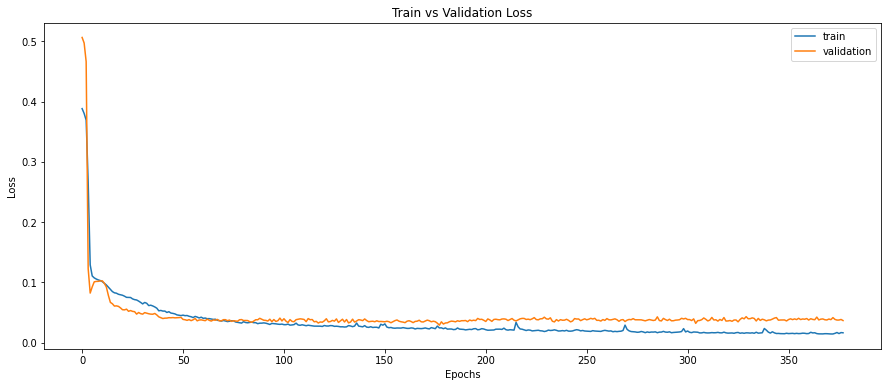

In [28]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
# SAVE AND LOAD MODEL
# model.save("model2.h5")

# load model
model = load_model('best_model_seq2seq.h5')

In [30]:
# prediction
y_pred = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
X_test_model = X_test[0].copy()
# print(X_test_model[0,0])
# print(X_test[0],X_test.shape)
# print(X_test_model,X_test_model.shape)
# print(y_pred.shape)
# print(y_test.shape)

In [31]:
for i in range(X_test.shape[0]):
    X_test_model = X_test_model.reshape(1,n_steps_in,n_features)

    pred = model.predict([X_test_model,np.zeros((X_test_model.shape[0],n_steps_out,n_features))], verbose=0)
    X_test_model=X_test_model.reshape(n_steps_in,n_features)
#     print(X_test_model)
#     print(X_test_model.shape)
#     print(pred[0])
#     print(pred.shape)
    y_pred[i]=pred
    if(n_steps_out>n_steps_in):
        X_test_model[0,:] = pred[-n_steps_in:]
    else:
        X_test_model[:-n_steps_out] = X_test_model[n_steps_out:]
        X_test_model[-n_steps_out:] = pred[0]

#     print(X_test_model)
    


In [32]:
y_test_re = y_test.reshape(n_steps_out*y_test.shape[0], n_features)
y_pred_re = y_pred.reshape(n_steps_out*y_pred.shape[0], n_features)
y_pred_inv = np.zeros_like(y_pred_re)
y_test_inv = np.zeros_like(y_test_re)
y_pred_inv = scaler.inverse_transform(y_pred_re)
y_test_inv = scaler.inverse_transform(y_test_re)

rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

Test RMSE: 59.459 


In [33]:
print(y_pred_re.shape)
print(y_test_re.shape)

(800, 6)
(800, 6)


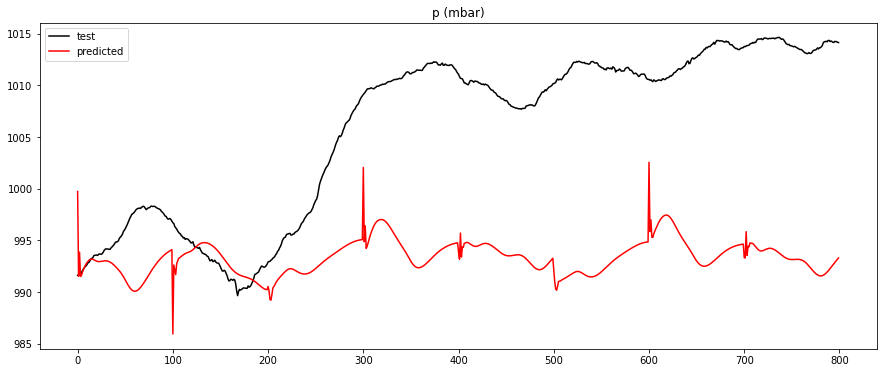

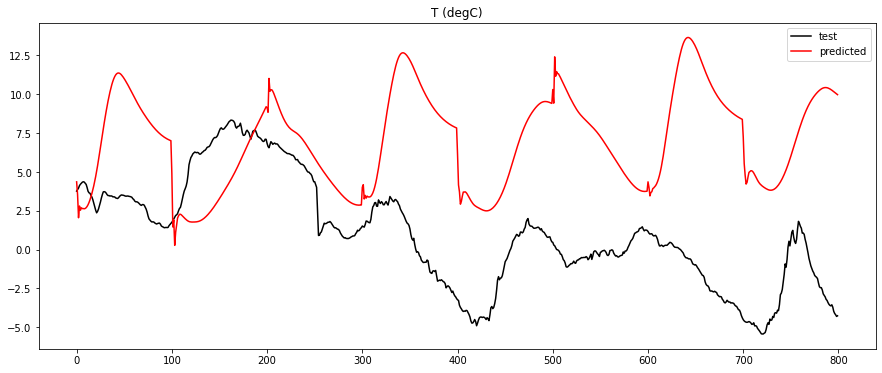

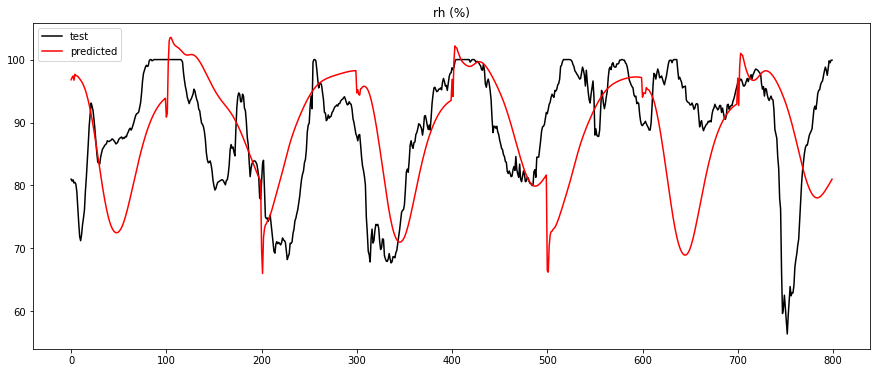

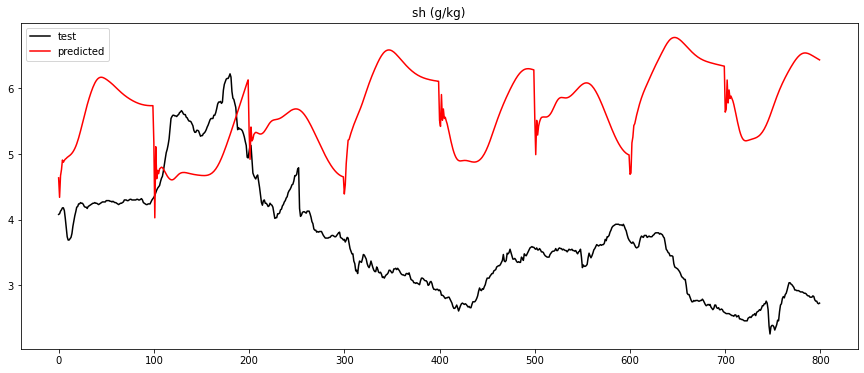

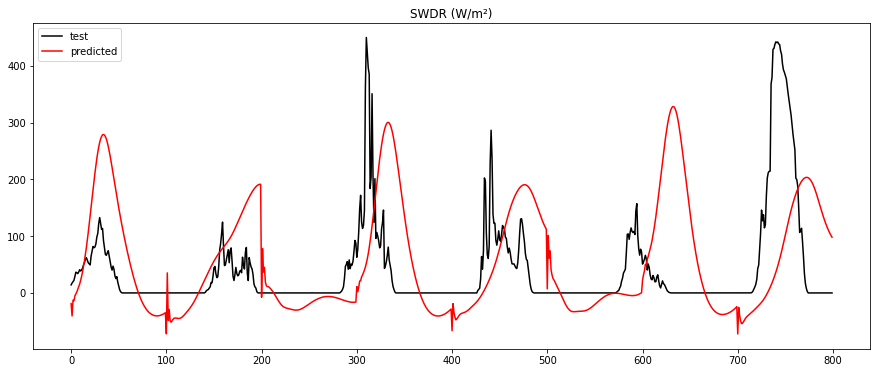

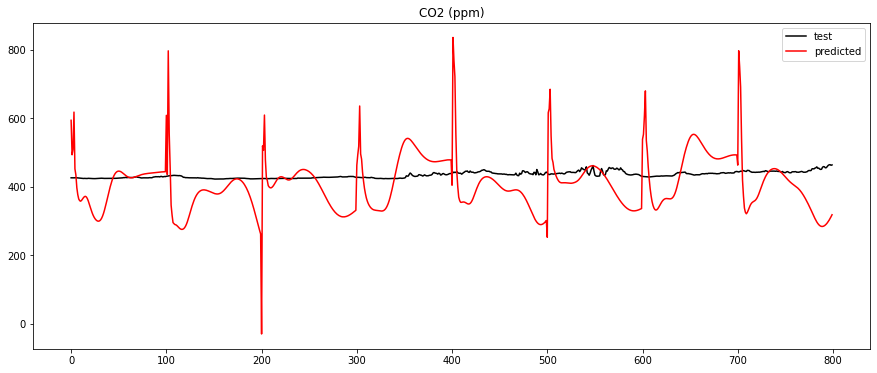

In [34]:
for i in range(n_features):
    plt.plot(y_test_inv[:,i],color='black')
    plt.plot(y_pred_inv[:,i],color='red')
    plt.legend(["test","predicted"])
    plt.title(col_names[i])
    plt.show()